# Time Series

- https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
- https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a

In [81]:
# importar pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#import matplotlib.pyplot as plt
import pickle
from tbats import TBATS, BATS

In [62]:
# definir parâmetros extras
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [63]:
# definir parâmetros extras
pd.set_option('precision', 4)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [64]:
input_prefix = 'data/'
#input_prefix = 'https://github.com/hjort/ai-labs/raw/master/jupyter/sales-russia/data/'

bzfile = '.bz2' # ''

In [121]:
df_train = pd.read_csv(
    input_prefix + '../sales_monthly.csv' + bzfile, #nrows=10000,
    #input_prefix + '../sales_monthly_full.csv' + bzfile, #nrows=10000,
    #input_prefix + '../train_full.csv' + bzfile, #nrows=10000,
    dtype={'date_block_num': np.int8, 'shop_id': np.int8, 'item_id': np.int16,
           'item_price_mean': np.int32, 'item_cnt_sum': np.int32,
           'city_code': 'category', 'item_category_id': 'category',
           'subject_code': 'category', 'group_code': 'category', 'subgroup_code': 'category'},
    index_col=['shop_id', 'item_id', 'date_block_num']
)
print('shape:', df_train.shape)
df_train.head()

/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


shape: (1608226, 2)


item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
0       30      1                           265            31
        31      1                           434            11
        32      0                           221             6
                1                           221            10
        33      0                           347             3

In [122]:
data = df_train.copy()
#data = df_train.drop(columns=['city_code', 'item_category_id', 'subject_code', 'group_code', 'subgroup_code'])

In [123]:
data.head()

item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
0       30      1                           265            31
        31      1                           434            11
        32      0                           221             6
                1                           221            10
        33      0                           347             3

In [124]:
data = data.query('(shop_id == 5) & (item_id == 5037)')
#data = data.query('(shop_id == 28) & (item_id == 20949)')
#data = data.query('(shop_id == 31) & (item_id == 20949)')
#data = data.query('(shop_id == 55) & (item_id == 492)')

In [125]:
data.head()

item_price_mean  item_cnt_sum
shop_id item_id date_block_num                               
5       5037    20                         2599             1
                22                         2599             1
                23                         1999             2
                24                         1999             2
                28                         1299             1

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9 entries, (5, 5037, 20) to (5, 5037, 32)
Data columns (total 2 columns):
item_price_mean    9 non-null int32
item_cnt_sum       9 non-null int32
dtypes: int32(2)
memory usage: 171.4 KB


In [127]:
data = data.reset_index().drop(columns=['shop_id', 'item_id']).set_index('date_block_num')
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
20,2599,1
22,2599,1
23,1999,2
24,1999,2
28,1299,1


In [128]:
data = pd.merge(pd.DataFrame({'date_block_num': np.arange(0, 34)}).set_index('date_block_num'),
         data, how='left', left_index=True, right_index=True)
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [129]:
data.tail()

,item_price_mean,item_cnt_sum
date_block_num,,
29,1499.0,1.0
30,1499.0,1.0
31,1000.0,3.0
32,750.0,1.0
33,NaN,NaN


In [130]:
data['item_cnt_sum'] = data['item_cnt_sum'].fillna(0).astype(np.int32)
data['item_price_mean'] = data['item_price_mean'].fillna(method='bfill').fillna(method='ffill').astype(np.int32)
data.head()

,item_price_mean,item_cnt_sum
date_block_num,,
0,2599,0
1,2599,0
2,2599,0
3,2599,0
4,2599,0


In [131]:
data.tail()

,item_price_mean,item_cnt_sum
date_block_num,,
29,1499,1
30,1499,1
31,1000,3
32,750,1
33,750,0


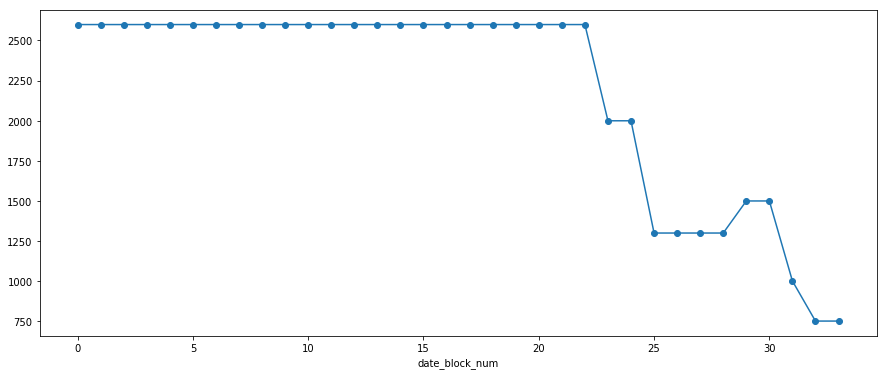

In [132]:
data['item_price_mean'].plot(marker='o')

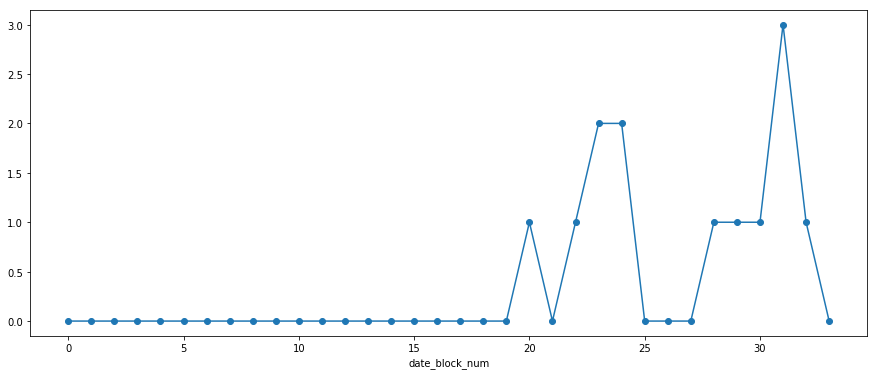

In [133]:
data['item_cnt_sum'].plot(marker='o')

array([<matplotlib.axes._subplots.AxesSubplot object at 0xa12b7d2c>,
      dtype=object)

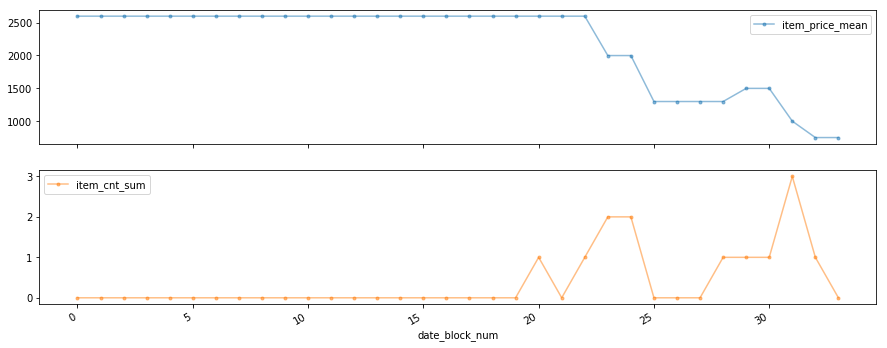

In [134]:
data.plot(marker='.', alpha=0.5, subplots=True)

In [17]:
# definir períodos a serem considerados no modelo
periodo1 = 1.0
periodo2 = 365.25

# definir data inicial de corte
data_inicio_amostra = '2014-11'

In [18]:
print('Períodos sazonais: (%.2f, %.2f)' % (periodo1, periodo2))
print('Data de início da amostra:', data_inicio_amostra)

Períodos sazonais: (1.00, 365.25)
Data de início da amostra: 2014-11


In [135]:
y = data['item_cnt_sum']

tamanho = len(y)
corte = int(np.ceil(tamanho * 0.75))
resto = tamanho - corte
print('Tamanho: %-3d\nCorte:   %-3d\nResto:    %-3d' % (tamanho, corte, resto))

y_train = y.iloc[:corte]
y_test = y.iloc[corte:]

Tamanho: 34 
Corte:   26 
Resto:    8  


In [136]:
y_train[:5]

date_block_num
0    0
1    0
2    0
3    0
4    0
Name: item_cnt_sum, dtype: int32

In [137]:
y_test[-5:]

date_block_num
29    1
30    1
31    3
32    1
33    0
Name: item_cnt_sum, dtype: int32

In [138]:
# Fit the model
estimator = TBATS(seasonal_periods=(12,), n_jobs=2)
%time model = estimator.fit(y_train)

/opt/anaconda3/lib/python3.6/site-packages/tbats/error/ExceptionHandler.py:13: InputArgsWarning: All seasonal periods should be values greater than 1. Ignoring all seasonal period values that do not meet this condition.
  warnings.warn(message, warning_type)


In [139]:
# Forecast 365 days ahead
y_forecast = model.forecast(steps=resto)
print(y_forecast)

y_forecast = y_forecast.round().astype(np.int32)
y_forecast

[0.88914359 0.88914359 0.88914359 0.88914359 0.88914359 0.88914359
 0.88914359 0.88914359]


array([1, 1, 1, 1, 1, 1, 1, 1])

In [140]:
y[-resto:].values

array([0, 0, 1, 1, 1, 3, 1, 0])

In [141]:
%time model = estimator.fit(y)

In [143]:
y_pred = model.forecast(steps=3)
y_pred = y_pred.round().clip(0, 20).astype(np.int32)
y_pred

array([1, 1, 1])

In [0]:
df_test = pd.read_csv(
    input_prefix + 'test.csv' + bzfile, #nrows=10000,
    dtype={'shop_id': np.int8, 'item_id': np.int16},
    index_col='ID')
print('shape:', df_test.shape)
df_test.head()

shape: (214200, 2)


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [0]:
ids = df_test.index
ids

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            214190, 214191, 214192, 214193, 214194, 214195, 214196, 214197,
            214198, 214199],
           dtype='int64', name='ID', length=214200)

In [0]:
X_pred = df_test.copy().reset_index().drop(columns=['ID'])
X_pred.head()

,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [0]:
df_shops = pd.read_csv(
    input_prefix + '../shops_full' + '.csv' + bzfile,
    dtype={'city_code': 'category'},
    index_col='shop_id')
print('shape:', df_shops.shape)
df_shops.drop(columns=['shop_name', 'city_name'], inplace=True)
df_shops.head()

shape: (60, 3)


,city_code
shop_id,
0,1
1,1
2,2
3,3
4,4


In [0]:
df_items = pd.read_csv(
    input_prefix + '../items_full' + '.csv' + bzfile,
    dtype={'item_category_id': 'category', 'subject_code': 'category',
           'group_code': 'category', 'subgroup_code': 'category'},
    index_col='item_id')
print('shape:', df_items.shape)
df_items.drop(columns=['item_name', 'subject_name', 'item_category_name', 'group_name', 'subgroup_name'], inplace=True)
df_items.head()

shape: (22170, 9)


,item_category_id,subject_code,group_code,subgroup_code
item_id,,,,
0,40,1803,11,8
1,76,111,15,31
2,40,1614,11,8
3,40,1958,11,8
4,40,2630,11,8


In [0]:
X_pred['date_block_num'] = 34
X_pred['item_price_mean'] = 0
X_pred.set_index(['shop_id', 'item_id', 'date_block_num'], inplace=True)
X_pred.head()

item_price_mean
shop_id item_id date_block_num                 
5       5037    34                            0
        5320    34                            0
        5233    34                            0
        5232    34                            0
        5268    34                            0

In [0]:
X_pred = X_pred.join(df_shops).join(df_items)
X_pred.head()

item_price_mean city_code item_category_id  \
shop_id item_id date_block_num                                               
5       5037    34                            0         5               19   
        5320    34                            0         5               55   
        5233    34                            0         5               19   
        5232    34                            0         5               23   
        5268    34                            0         5               20   

                               subject_code group_code subgroup_code  
shop_id item_id date_block_num                                        
5       5037    34                      793          6            13  
        5320    34                      818         13             6  
        5233    34                      786          6            13  
        5232    34                      786          6            19  
        5268    34                      786          6            14

In [0]:
y_pred = model.predict(X_pred)
y_pred[:30]

array([ 1.88292211,  2.03189192,  1.88292211,  1.85285458,  2.18216991,
        1.85285458,  2.18216991,  2.03189192,  2.03189192,  2.18216991,
        2.06270293,  2.18216991,  2.03189192,  1.85285458,  1.85285458,
        1.88292211, 11.78756569,  2.03189192,  2.06270293,  2.18216991,
        2.03189192,  1.88292211,  2.24096826,  1.88292211,  2.06270293,
        2.18216991,  1.85285458,  2.11946414,  2.34529601,  2.34529601])

In [0]:
#y_pred = np.clip(y_pred, 0, 20)
#y_pred = np.clip(np.round(y_pred), 0, 20)
y_pred = np.clip(np.floor(y_pred), 0, 20)
y_pred[:30]

array([ 1.,  2.,  1.,  1.,  2.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        1.,  1.,  1., 11.,  2.,  2.,  2.,  2.,  1.,  2.,  1.,  2.,  2.,
        1.,  2.,  2.,  2.])

In [0]:
df_final = pd.DataFrame(data=y_pred, columns=['item_cnt_month'], index=ids)
df_final.index.names = ['ID']
df_final.head()

,item_cnt_month
ID,
0,1.0
1,2.0
2,1.0
3,1.0
4,2.0


In [0]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 1 columns):
item_cnt_month    214200 non-null float64
dtypes: float64(1)
memory usage: 3.3 MB


In [0]:
df_final.describe()

,item_cnt_month
count,214200.0000
mean,5.0916
std,6.0712
min,0.0000
25%,1.0000
50%,3.0000
75%,5.0000
max,20.0000


In [0]:
df_final.to_csv('submission6.csv')